<b> Title: </b> Group 11 Final Project Report - DSCI 100 002 

<b> Group members: </b> Katie Archer, Noor Naila Imtinan Himam, Matthew Yeung, Wenwen Zhao

<b>1. Introduction</b>
<br>
According to scientific research, pulsars are an uncommon form of neutron stars that emit regular pulses of radiation, varying from several seconds to milliseconds in frequency. The potent magnetic fields of these stars generate intense beams of light at both poles. These beams are periodically observed as the pulsar rotates quickly, and they can only be observed with large telescopes when they cross our line of sight from Earth (National Aeronautics and Space Administration, n.d.)

Although pulsars emit a pattern of radio emission that can be detected as they rotate, it can be challenging to distinguish between genuine signals and background noise. Pulsar candidates are being classified as binary classification issues using machine learning tools. The HTRU 2 dataset, which is used to train classification models, includes examples of both real and fake pulsar signals. The class labels used are 0 (negative) and 1 (positive), with the legitimate pulsar examples being the minority positive class. The eight continuous variables are obtained from the integrated pulse profile and the DM-SNR (Disperion Measure-Signal-to-Noise Ratio) curve, which describes the longitude-resolved version of the signal averaged in both time and frequency (Keith et al., 2010). Each candidate in the dataset is described by eight continuous variables, one class variable, and no astronomical information. The integrated pulse profile and the DM-SNR curve are used to determine the eight variables.

In this project, we aim to produce a KNN classification model from the integrated pulse profile and DM-SNR curve of pulsar candidates to classify whether signals are legitimate or spurious (real or fake pulsar). The data will be used to explore the correlation between two variables, the class imbalance and the combination of predictors that would create a model with the greatest accuracy.

<b>2. Preliminary exploratory data analysis:</b>


First, we load all of the libraries that we will need for the remainder of this project. This includes installing a package that will allow us to upsample our dataset later on.

In [1]:
#CAUTION: Takes a long time to load.
install.packages("themis")
install.packages("tidymodels")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(GGally)
install.packages("corrplot")
library(corrplot)
library(RColorBrewer)   
library(class)          
library(e1071)          
library(stringr)
library(themis)
devtools::install_github("tidymodels/tune")
set.seed(1)
options(repr.matrix.max.rows = 10)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4          ✔ rsample      1.1.1     
✔ dials        1.2.0          ✔ tune         1.1.1.9000
✔ infer        1.0.4          ✔ workflows    1.1.3     
✔ modeldata    1.1.0          ✔ workflowsets 1.0.1     
✔ parsnip      1.1.0          ✔ yardstick    1.1.0     
✔ recipes   

<b>Summarize the data in at least one table </b>

We begin by reading in our dataset and tidying it by adding column names and removing any rows with missing values.

In [3]:
pulsar_data <- read_csv("pulsar_data.csv", col_names = c("mean_integrated_profile", "stand_dev_integrated_profile", "exc_kurtosis_integrated_profile", 
                                                         "skew_integrated_profile", "mean_dmsnr", "stand_dev_dmsnr", "exc_kurtosis_dmsnr", 
                                                         "skew_dmsnr", "class"))
pulsar_data <- pulsar_data |> 
    drop_na() |>
    mutate(class = as_factor(class))
head(pulsar_data)
#not sure how to add table numbers
#this is table 1

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


<b> Dataset Exploration Graph 1 (correlation): </b>

In [23]:
options(repr.plot.width = 12, repr.plot.height = 12)
#ERROR!
cor_pulse <- cor(pulsar_data)
corrplot(cor_pulse, type="upper", order="hclust",col=brewer.pal(n=8, name="RdYlBu")) 
#need to add a "Figure 1" with a title

ERROR: Error in cor(pulsar_data): 'x' must be numeric


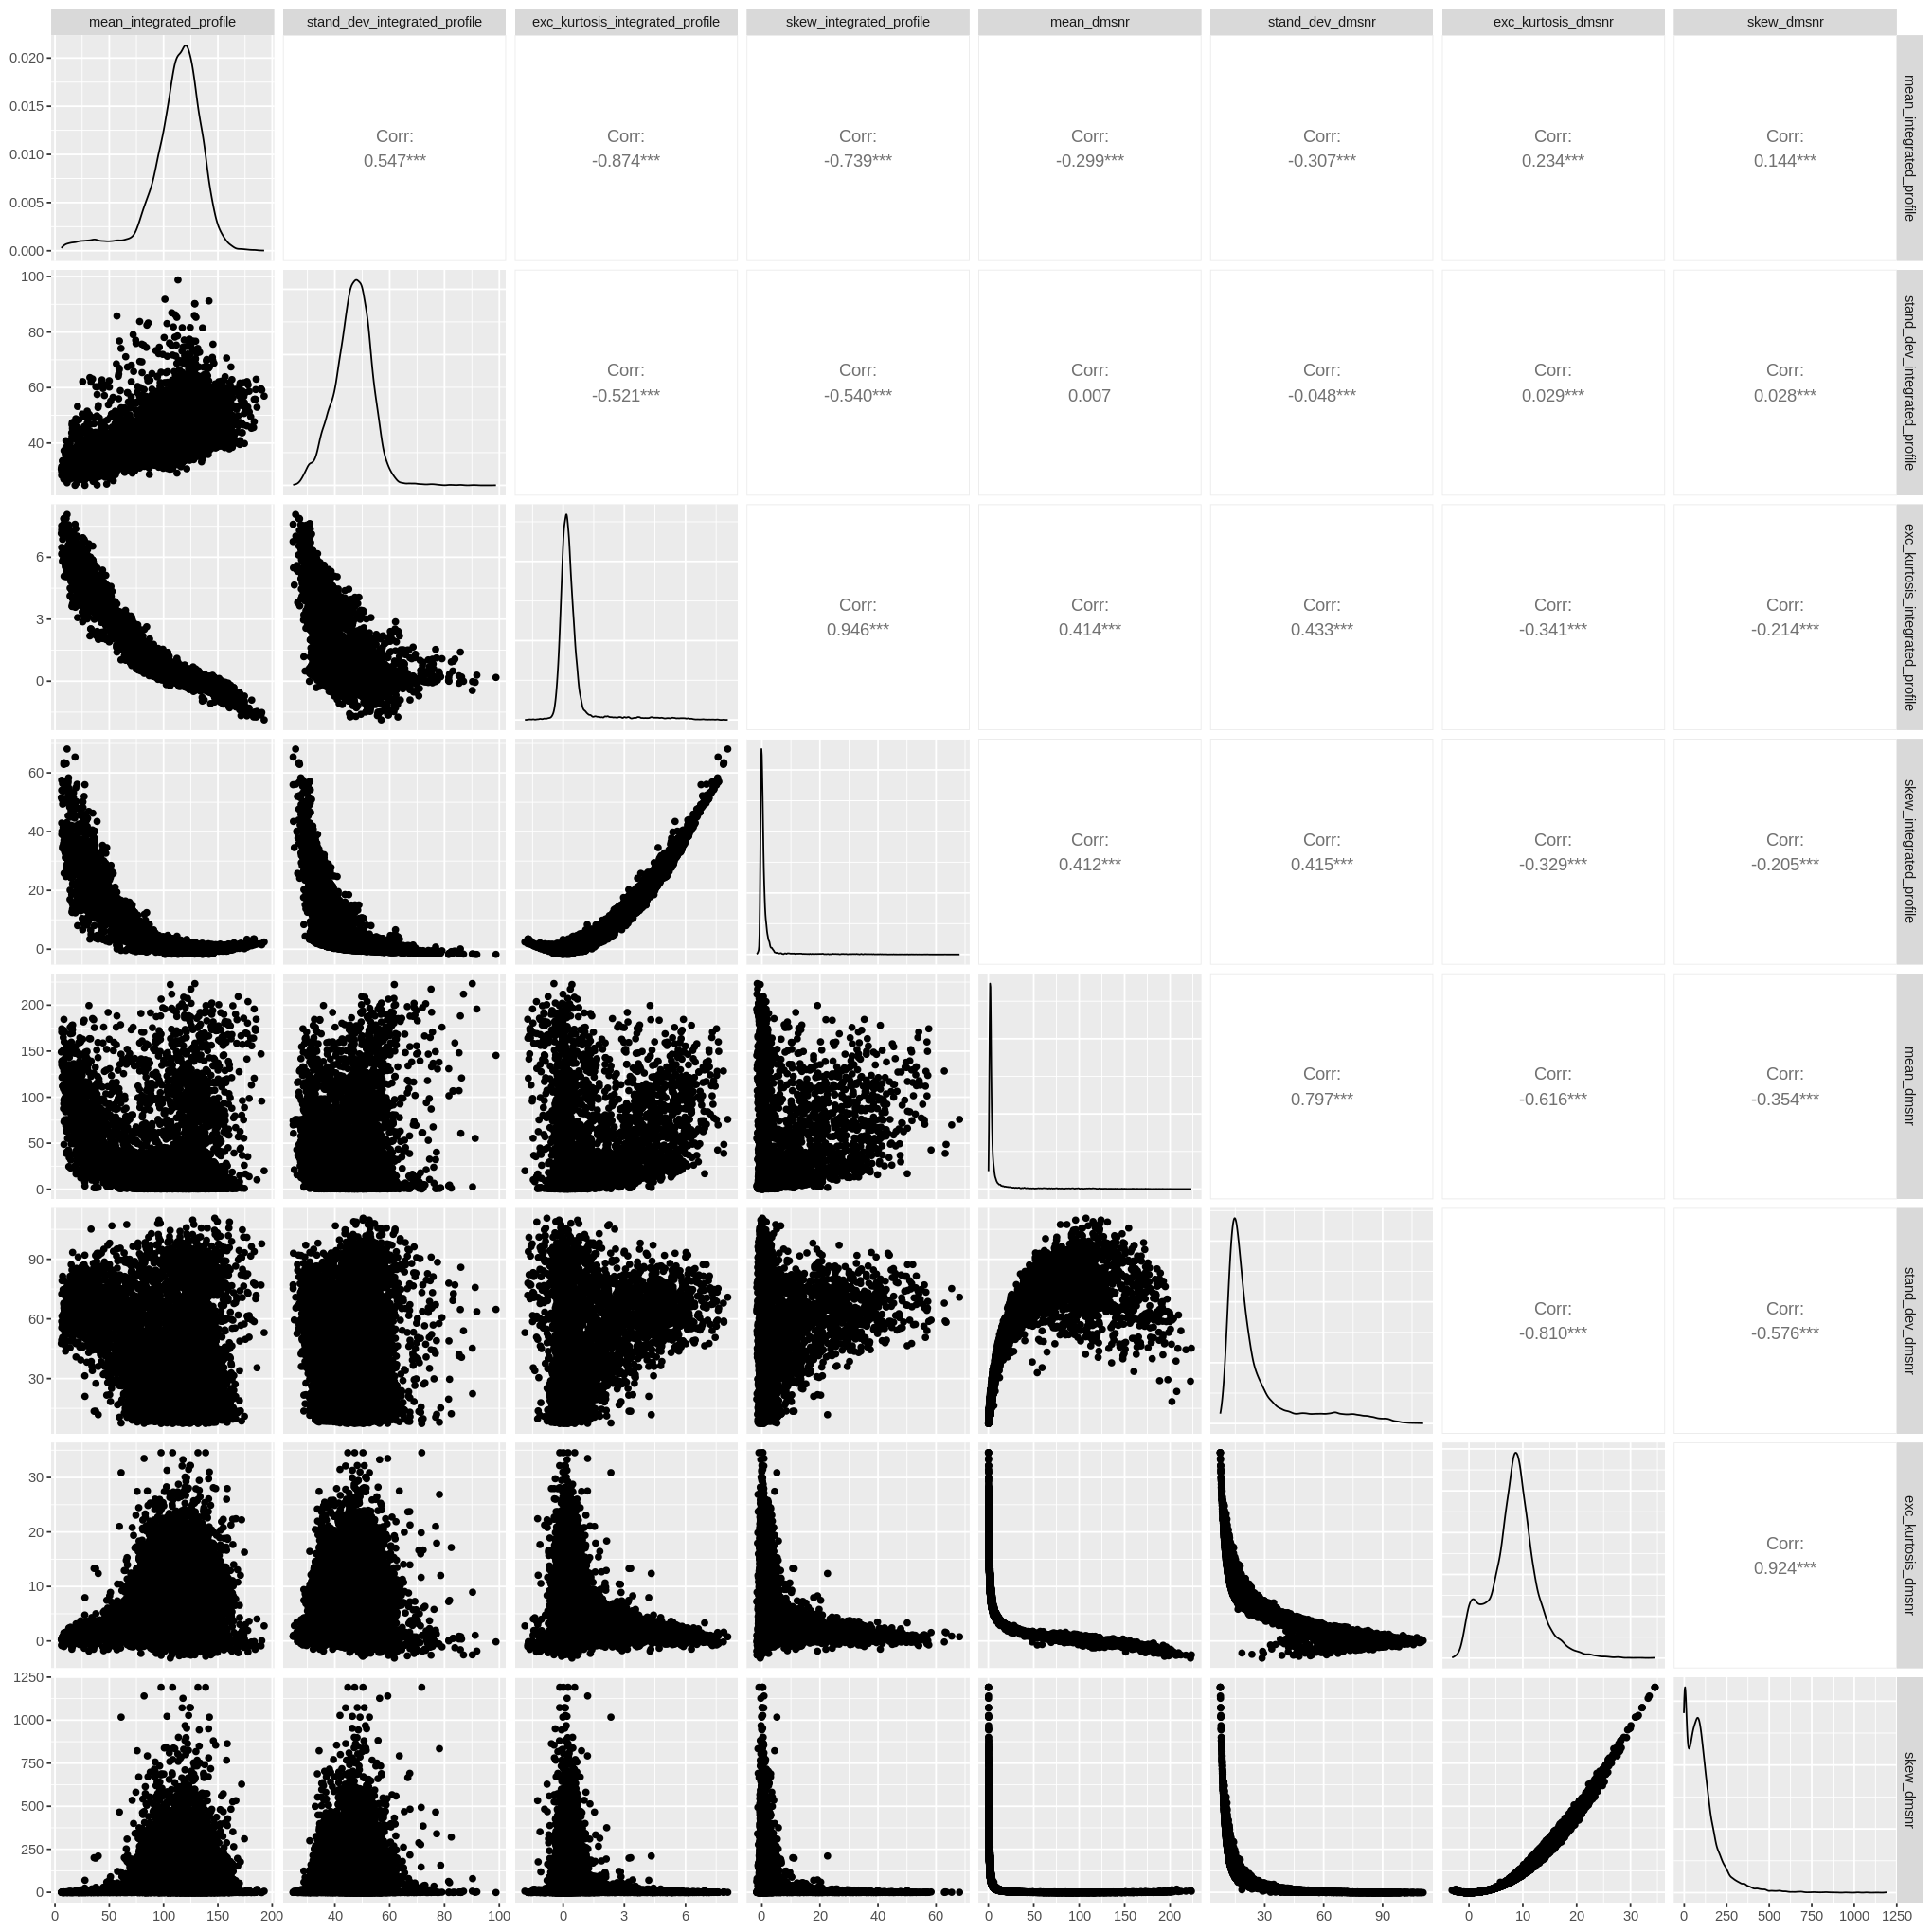

In [24]:
options(repr.plot.width = 17, repr.plot.height = 17)
pm_pairs <- select(pulsar_data, "mean_integrated_profile":"skew_dmsnr")%>%
ggpairs()

pm_pairs

We can see that various pairs of variables have a different correlation value, where some have higher correlation values than others. *** 

<b> Dataset Exploration Graph 2 (variable distribution): </b>

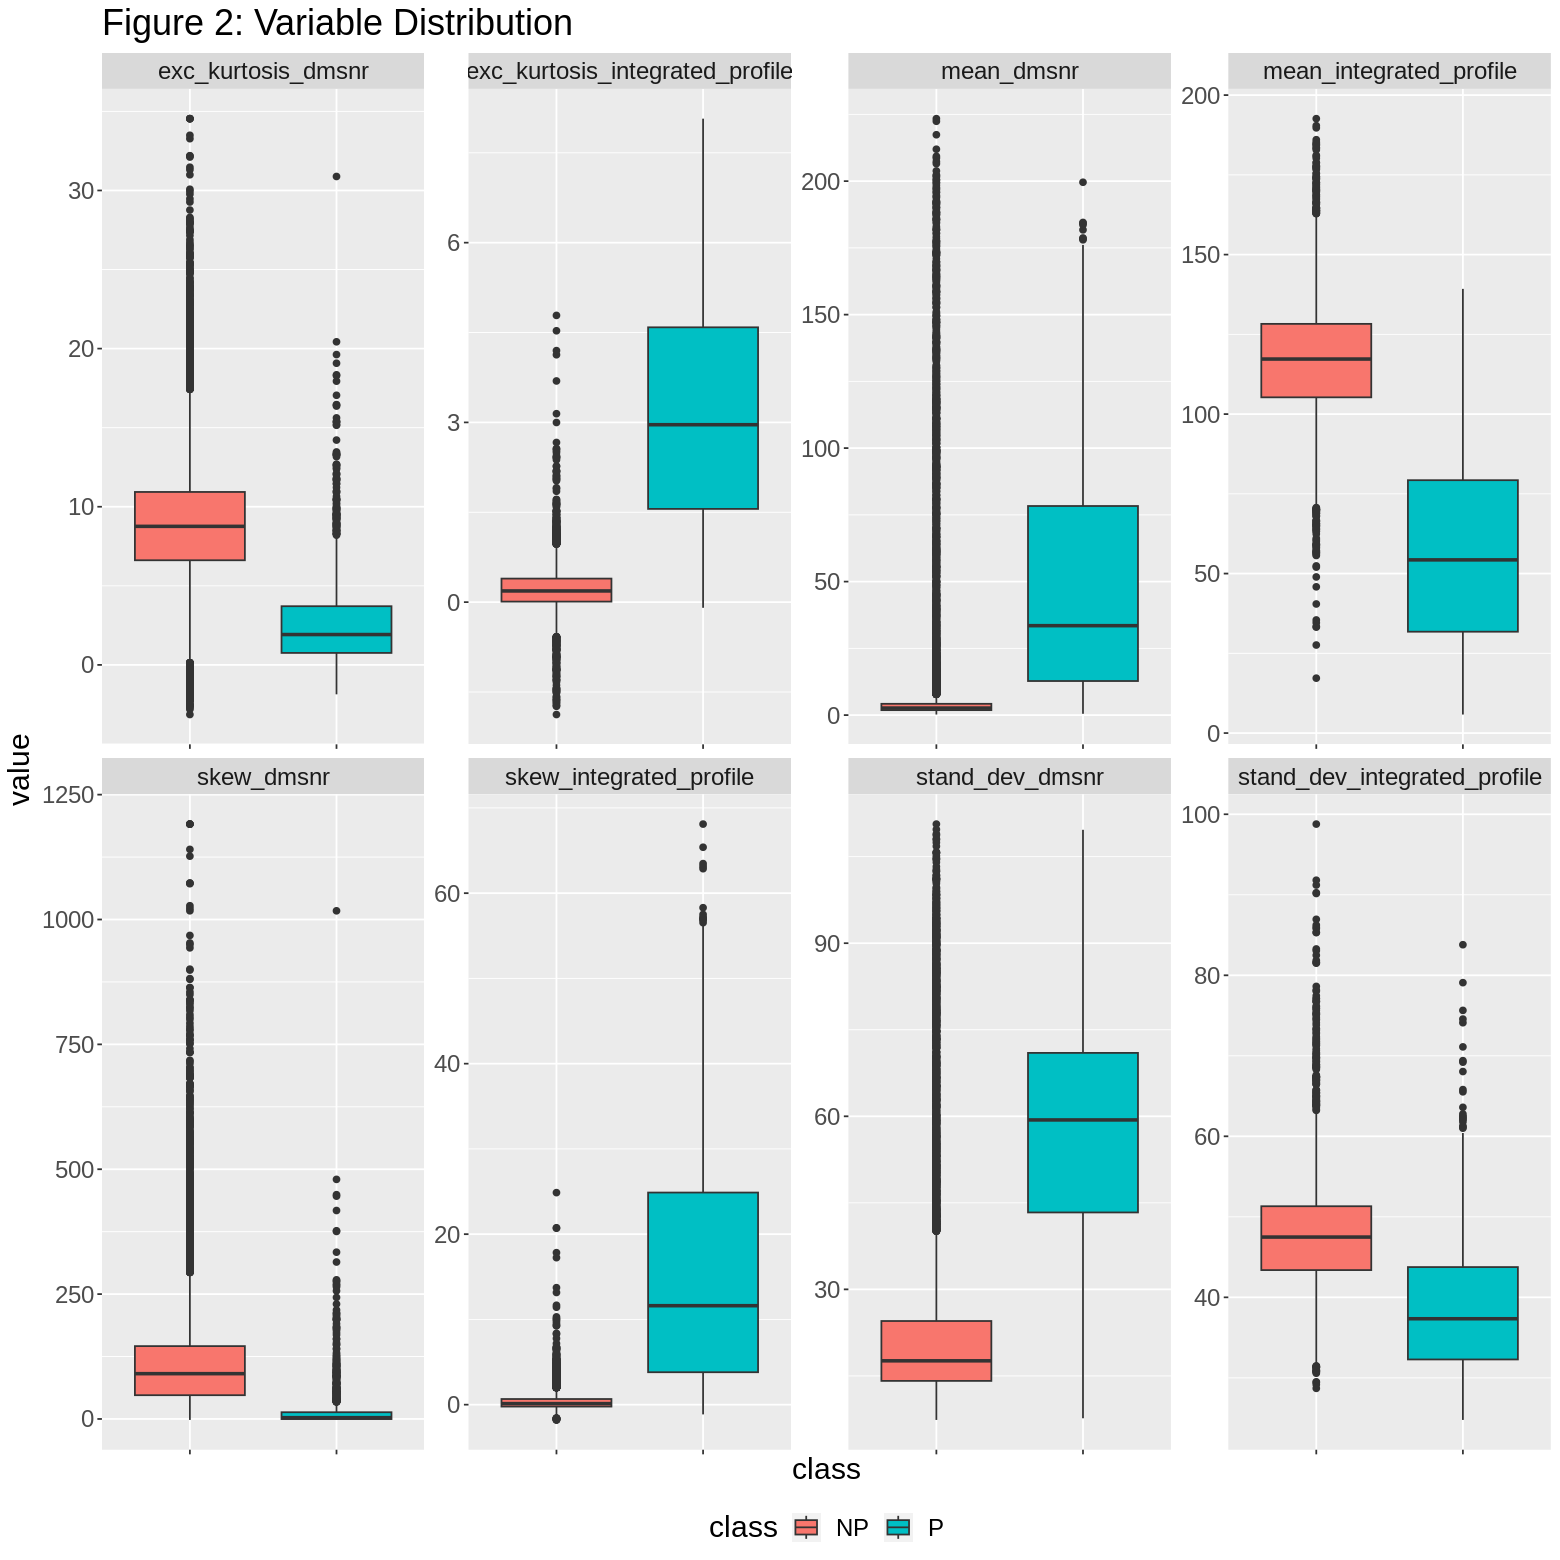

In [12]:
pulsar_data$class <- ifelse(pulsar_data$class == 1, "P", "NP")

options(repr.plot.height = 13, repr.plot.width = 13)

pulsar_data |> gather(predictors, value, -class) %>%
  ggplot(aes(class, value, fill = class)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free", ncol = 4) +
  theme(axis.text.x = element_blank(), legend.position="bottom") +
  theme(text = element_text(size = 18)) +
  ggtitle("Figure 2: Variable Distribution")

As shown above, the distribution graph above shows that some of the variables' values show a distinct difference between real and false pulsars.

Now, we look at the proportion of pulsars and non pulsars in the dataset to determine a data balancing method:

In [25]:
prop.table(table(pulsar_data$class))


        NP          P 
0.90842552 0.09157448 

In [26]:
table(pulsar_data$class)


   NP     P 
16259  1639 

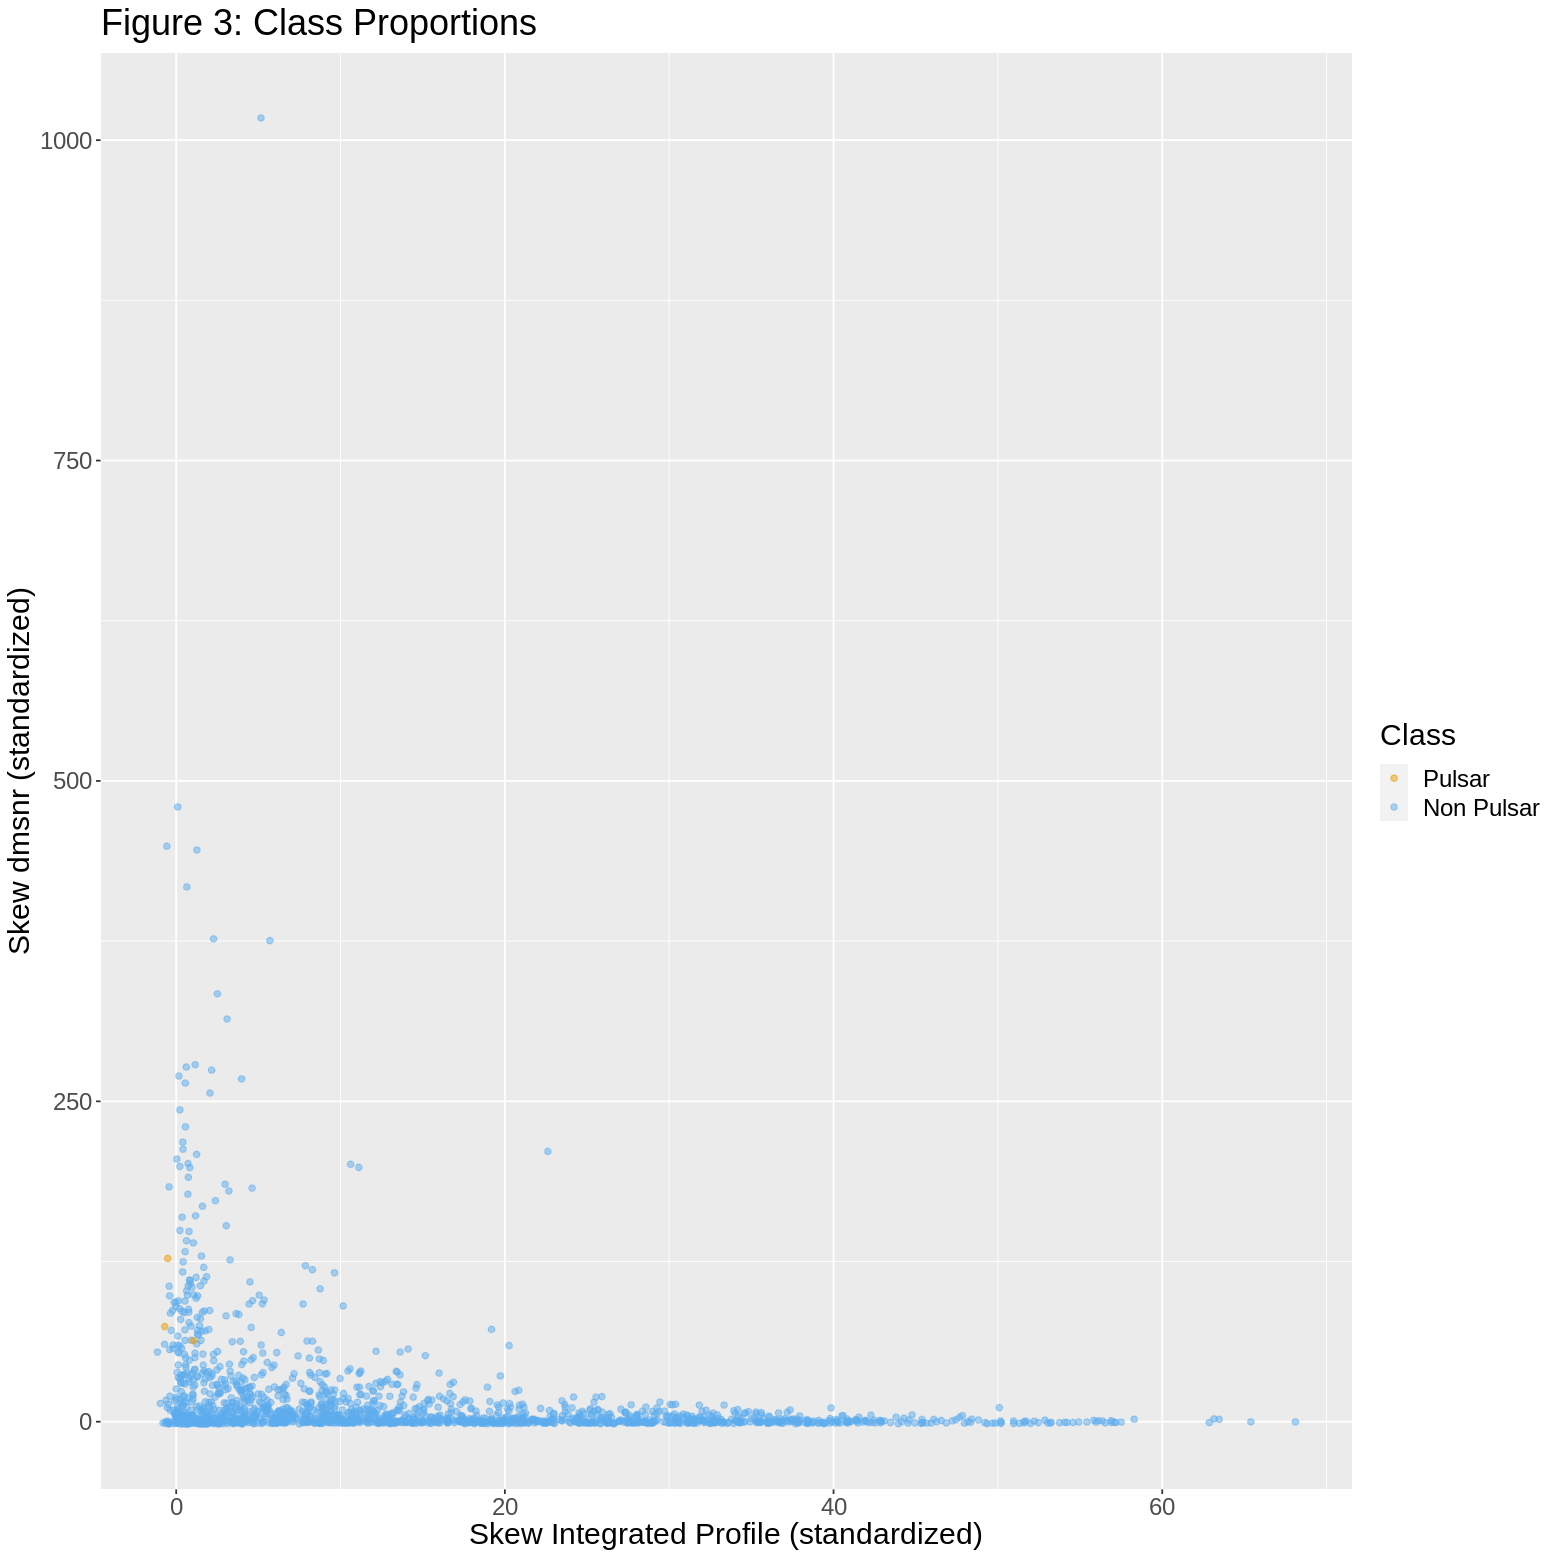

In [15]:
rare_pulsar <- bind_rows(
      filter(pulsar_data, class == "P"),
      pulsar_data |> filter(class == "NP") |> slice_head(n = 3)
    ) |>
    select(class, skew_integrated_profile, skew_dmsnr)

rare_plot <- rare_pulsar |>
  ggplot(aes(x = skew_integrated_profile, y = skew_dmsnr, color = class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Skew Integrated Profile (standardized)", 
       y = "Skew dmsnr (standardized)",
       color = "Class") +
  scale_color_manual(labels = c("Pulsar", "Non Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 18)) +
  ggtitle("Figure 3: Class Proportions")

rare_plot

As we can see from the proportions and the plot shown above in Figure 3, which uses two variables from the dataset, there are more non pulsars than pulsars. We must balance the number of pulsar points in the training set, otherwise our KNN classification model will be more likely to pick non pulsar as the majority class. Thus, the algorithm model will not learn correctly. 

For our purposes in this project, it will suffice to rebalance the data by oversampling the rare class. We will randomly duplicate observations of class 1 (real pulsars) until we have the same number of class 0 and class 1 in our training set.

**Selecting Predictors**

To address our project question, we perform forward selection to determine how accurate our classification model would be, given various predictor combinations. We select the set of predictors that is expected to yield the most accurate classifier in our data analysis.

In [16]:
names <- colnames(pulsar_data |> select(-class))
names

[1] "mean_integrated_profile"         "stand_dev_integrated_profile"   
[3] "exc_kurtosis_integrated_profile" "skew_integrated_profile"        
[5] "mean_dmsnr"                      "stand_dev_dmsnr"                
[7] "exc_kurtosis_dmsnr"              "skew_dmsnr"

In [17]:
example_formula <- paste("class", "~", paste(names, collapse="+"))
example_formula

[1] "class ~ mean_integrated_profile+stand_dev_integrated_profile+exc_kurtosis_integrated_profile+skew_integrated_profile+mean_dmsnr+stand_dev_dmsnr+exc_kurtosis_dmsnr+skew_dmsnr"

In [18]:
# create an empty tibble to store the results
predictor_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

In [ ]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        puls_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())                        
        
        #set up a model
        knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")                                        

        puls_vfold <- vfold_cv(pulsar_data, v = 10, strata = class)
        
        # tune the KNN classifier with these predictors
        acc <- workflow() |>
          add_recipe(puls_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = puls_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
predictor_accuracies <- predictor_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
predictor_accuracies
#add table number

Based on the data above, the highest accuracy is obtained by using the 4 following predictors: exc_kurtosis_integrated_profile, stand_dev_dmsnr, stand_dev_integrated_profile, and mean_dmsnr.

<b>Data Analysis and Results </b>

Since we loaded our libraries at the beginning of the report, read in our data, we can begin our data analysis by inspecting the dataset. We see that the percentage of observations corresponding to real pulsars is roughly 9%. 

In [19]:
#Class proportions in pulsar data set (Imbalanced)
num_obs <- nrow(pulsar_data)
pulsar_proportions <- pulsar_data |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_data))
pulsar_proportions

class,n,percent
<chr>,<int>,<dbl>
NP,16259,90.842552
P,1639,9.157448


Here, we randomly split our data into a training and testing set, using 75% of the data to train our classification model. As mentioned earlier, we balance the proportions of real pulsars to false pulsar observations by upsampling the training set only (create more real pulsar observations that have predictor values similar to those in the original set). The testing set will not be upsampled as this will be used to test our accuracy. To preprocess the data, we scale and center our predictors such that the variables have a mean of 0 and standard deviation of 1. We also build our recipe with the 4 predictors that yields the highest performance, obtained from forward selection. 

In [20]:
set.seed(1)
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 


#Standardize and Upsample data to balance the training set
pulsar_recipe <- recipe(class ~ ., data = pulsar_train) |>                   #input the 4 predictors we obtained from forward selection
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    themis::step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep()
pulsar_recipe

pulsar_train <- bake(pulsar_recipe, pulsar_train)
pulsar_train

pulsar_recipe <- recipe(class ~ ., data = pulsar_train)

#Check new proportions in training set
new_pulsar_proportions <- pulsar_train |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(pulsar_train))
new_pulsar_proportions
#add table number



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 8



── Training information 

Training data contained 13423 data points and no incomplete rows.



── Operations 

• Scaling for: mean_integrated_profile, ... | Trained

• Centering for: mean_integrated_profile, ... | Trained

• Up-sampling based on: class | Trained



mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.3382028,1.80673446,-0.009077165,-0.3682483,-0.3705891,-0.5859249,0.5078324,0.2171164,NP
-0.3182986,-1.05924615,-0.143049363,-0.1145006,-0.3210346,-0.2330929,-0.1273024,-0.3951781,NP
1.0039566,1.55681725,-0.512672218,-0.3878759,-0.3031295,-0.2733441,-0.3149639,-0.4864979,NP
-0.6885178,0.01970171,0.053749649,-0.2172864,-0.3719951,-0.6020723,0.5179523,0.2552567,NP
0.3272118,0.32285369,-0.418436890,-0.3029714,-0.3938600,-0.8719274,2.4373284,3.5765731,NP
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-3.00874182,-2.1534919,3.8811359,3.9084502,0.8392652,1.9072175,-1.4380657,-0.9719605,P
-3.22064561,-0.4111971,3.0779063,1.8956762,2.0203681,2.3648486,-1.7075928,-1.0024231,P
-0.99198116,-0.2663260,0.7525602,0.1399375,0.3947089,1.3811141,-1.3643983,-0.9603344,P


class,n,percent
<fct>,<int>,<dbl>
NP,12200,50
P,12200,50


Now we perform cross-validation on the training set in order to select the best K parameter value for our classifier (number of neighbors). To do this, we perform 10-fold cross-validation. But first, we build a classification model that specifies that we want to tune the number of neighbors. We create a tibble that contains each K value that we want to test.

In [ ]:
#build the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#Create a tibble for the K values
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 3))
#k_vals       #add table number

#Set up and perform 10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics() #assess the accuracy 
knn_results
#add table number

To determine the best K to use, we filter the metrics collected from cross validation and plot the accuracy against the K values we tested.

In [ ]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle(" Figure 4: Accuracy vs. K") +
       theme(text = element_text(size = 20))
accuracy_versus_k

Based on the above plot, we see that the accuracy decreases quite steeply as the number of neighbors increases, before leveling off from around K = 16 onwards. We choose K = 17 for our classification model because the accuracy is high at this point, and the accuracy does not change drastically when looking at similar K values. Overall, we want to avoid overfitting the data by selecting too few neighbors, and 17 is an odd number (given that K-nearest neighbors classifies observations based on a majority rules system, using an even number of neighbors could be problematic in the event of a tie, since our class variable is binary). 

Upon determining the optimal K value for our classifier, we can finally predict on our testing set. As done below, we use the same recipe as before, but a new model that sets the number of neighbors to 17 must be built. Once we have used the model to predict the classes of the observations in the test set, we take a confusion matrix to view the accuracy.

In [ ]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
                    set_engine("kknn") |>
                    set_mode("classification")

pulsar_fit_final <- workflow() |>
        add_recipe(pulsar_recipe) |>
        add_model(knn_spec_final) |>
        fit(data = pulsar_train)

pulsar_test_predictions_final <-  predict(pulsar_fit_final, pulsar_test) |>
        bind_cols(pulsar_test)

pulsar_test_predictions_final                

confusion_final <- pulsar_test_predictions_final |>
    conf_mat(truth = class, estimate = .pred_class)
confusion_final

To visualize the accuracy of our classification model, we create a new column in the predictions table that will allow us to visualze the test data in such a way that colour-coding the observations will let us see the information stored in the confusion matrix. (***not worded very well)

In [ ]:
mutated_predictions <- pulsar_test_predictions_final |>
    mutate(new_cat = case_when(.pred_class == 0 & class == 0 ~ "False pulsar, correctly classified",
                               .pred_class == 1 & class == 1 ~ "Real pulsar, correctly classified",
                               .pred_class == 1 & class == 0 ~ "False pulsar, incorrectly classified",
                               .pred_class == 0 & class == 1 ~ "Real pulsar, incorrectly classified"))
mutated_predictions
#add table number

<b> Visualization: Classifier accuracy </b>

In [ ]:
options(repr.plot.height = 10, repr.plot.width = 14)

#First 2 predictors
plot_1 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = exc_kurtosis_integrated_profile, 
                                                              y = mean_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Excess Kurtosis - Integrated Profile", y = "Scaled Mean - DMSNR curve", colour = "Prediction") +
    ggtitle("Figure 5: Classifier accuracy with regards to mean of DMSNR
                \ncurve and excess kurtosis of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_1



#Next 2 predictors
plot_2 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = skew_dmsnr,
                                                              y = skew_integrated_profile, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Skewness - DMSNR curve", y = "Scaled Skewness - Integrated Profile", colour = "Prediction") +
    ggtitle("Figure 6: Classifier accuracy with regards to skewkness
                \nof both DMSNR curve and integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_2



#Last 2 predictors
plot_3 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = stand_dev_integrated_profile, 
                                                             y = exc_kurtosis_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Standard Deviation - Integrated Profile", y = "Scaled Excess Kurtosis - DMSNR curve", colour = "Prediction") +
    ggtitle("Figure 7: Classifier accuracy with regards to excess kurtosis of
                \nDMSNR curve and standard deviation of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_3

As can be seen above, there are very few observations in the testing set that were incorrectly classified. This indicates that our model is quite accurate. We can represent the accuracy of our model as a percentage, as well:

In [ ]:
#From the confusion matrix:

accuracy_perc <- ((3838 + 3853)/8130)*100
accuracy_perc

Therefore, <b> ~__% </b> is a good estimate of how accuracte our classification model is.

<b>Discussion </b>

summarize what you found: We found that training a classifier with our predictors (name them*) yields the most accurate predictions on new observations (i.e. the testing set). The accuracy of our model is __.

discuss whether this is what you expected to find?
- Personally, before upsampling I wasn’t expecting a really high prediction accuracy with any combination of predictors, due to how rare the real pulsars were in the original dataset
- Also, I don’t think I was expecting that the most accurate classifier would come from using 6 of the 8 variables available to us in the dataset → in our class readings it was mentioned that using very few or many predictors often harms how good the classifier is at making predictions (would have expected between 2-4 predictors to give the highest accuracy)

discuss what impact could such findings have?

discuss what future questions could this lead to?

**References**

Dr Robert Lyon, University of Manchester, School of Physics and Astronomy, Alan Turing Building, Manchester M13 9PL, United Kingdom, robert.lyon '@' manchester.ac.uk

Keith, M. J., et al. (2010). The HTRU survey. Handbook of pulsar astronomy, 379-422.

United States. National Aeronautics and Space Administration. NASA technical note. Washington :National Aeronautics and Space Administration.

Paula, G. (2020, February 5). Creating a new variable under conditions of other two variables. Posit Community. Retrieved April 13, 2023, from https://community.rstudio.com/t/creating-a-new-variable-under-conditions-of-other-two-variables/51825  

do we need to cite the textbook?
do we need embedded citations?